# Building Adjacency Matrix Based on SKB-DA
---
By Xiaoran Li
For JSAI2022

# Definition

In [1]:
import pickle as pkl
import math
from tqdm import tqdm
import os
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import nltk
import numpy as np
import re
import glob
import sys
import json
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from nltk.stem import WordNetLemmatizer
from scipy import linalg, mat, dot, stats

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load STC dataset

In [415]:
dataset_name = 'Ohsumed'
#dataset_name = 'Snippets'

STC_Benchmark_path = "../benchmark"
stopword_en_path = "{}/stopwords_en.txt".format(STC_Benchmark_path)
os.makedirs(f'{STC_Benchmark_path}/{dataset_name}_over', exist_ok=True)

if dataset_name == 'Ohsumed':
    train_dict: dict = np.load("{}/{}/train.npy".format(STC_Benchmark_path,dataset_name), allow_pickle=True).tolist()
    test_dict: dict = np.load("{}/{}/test.npy".format(STC_Benchmark_path,dataset_name), allow_pickle=True).tolist()
    all_ = dict(train_dict, **test_dict)
    print(len(all_))
        
if dataset_name == 'Snippets':
    train_dict = json.load(open('{}/{}/snippets_split.json'.format(STC_Benchmark_path,dataset_name)))['train']
    test_dict = json.load(open('{}/{}/snippets_split.json'.format(STC_Benchmark_path,dataset_name)))['test']
    all_ = {items['text']:items['label'] for items in train_dict.values()}
    for items in test_dict.values():
        if items['text'] in all_.keys() and items['label'] != all_[items['text']]:
            print("ERROR: ",items['text'],items['label'],all_[items['text']])
            del all_[items['text']]
            continue
        all_[items['text']] = items['label']


7398


## Load SKB dataset

In [5]:
SKB_dataset_name = 'skb_da'
SKB_Benchmark_path = "../sememe_dataset"

skb_da = np.load("{}/{}_dict.npy".format(SKB_Benchmark_path, SKB_dataset_name), allow_pickle=True).tolist()
dictskb = np.load("{}/DictSKB_dict.npy".format(SKB_Benchmark_path), allow_pickle=True).tolist()
networdskb = np.load("{}/sememe_network_dict_en_wordnet_5000.npy".format(SKB_Benchmark_path),\
                     allow_pickle=True).tolist()

In [ ]:
### for networks

In [169]:
def netWordSKBForm(networdskb):
    '''uniform for NetWordSKB'''
    networdskb_form = {}
    for wn_k,wn_v in networdskb.items():
        word = wn_k.split(".")[0]
        if word not in networkskb_form.keys():
            networdskb_form[word] = []
        networdskb_form[word].append((wn_k.split(".")[1],wn_v))
    return networdskb_form

### Move Wiki keys To Sense on SKBDA
And Get SKB-DA CDV

In [6]:
def cleanSKB(skb):
    clean_skb = {}
    for word, items in skb.items():
        if word not in clean_skb.keys():
            clean_skb[word] = []
        for (pos, sememe_set) in items:
            if word in clean_skb.keys() and len(sememe_set) != 0: 
                clean_skb[word].append((pos, sememe_set))
    return clean_skb

def removeWikiSenseOnSKBDA(skb_da_dict):
    '''uniform for SKB-DA sense'''
    skb_da_pure_dict = {}
    skb_da_cdv_set = set()
    for word, sense in tqdm(skb_da_dict.items()):
        for (pos, sememe_set) in sense:
            if " (" in word:
                if len(word.split(" (")) == 3:
                    word, sense1,sense2 = word.split(" (")
                    sense1 = sense1.replace(")","")
                    sense2 = sense2.replace(")","")
                    if word not in skb_da_pure_dict.keys():
                        skb_da_pure_dict[word] = []
                    #sememe_set.add(sense1)
                    #sememe_set.add(sense2)
                    sememe_set.discard(word)
                    skb_da_pure_dict[word].append((sense1+" - "+sense2,sememe_set))
                    skb_da_cdv_set =  skb_da_cdv_set | sememe_set
                    continue
                word, sense = word.split(" (")
                sense = sense.replace(")","")
                if word not in skb_da_pure_dict.keys():
                    skb_da_pure_dict[word] = []
                #sememe_set.add(sense)
                sememe_set.discard(word)
                skb_da_pure_dict[word].append((sense,sememe_set))
                skb_da_cdv_set =  skb_da_cdv_set | sememe_set
            else:
                if word not in skb_da_pure_dict.keys():
                    skb_da_pure_dict[word] = []
                sememe_set.discard(word)
                skb_da_pure_dict[word].append((pos,sememe_set))
                skb_da_cdv_set =  skb_da_cdv_set | sememe_set
    print("#all lexicon of SKB-DA: {}; #CDV of SKB-DA: {}".format(len(skb_da_pure_dict),len(skb_da_cdv_set)))
    return cleanSKB(skb_da_pure_dict),skb_da_cdv_set

In [7]:
skb_da_pure,skb_da_pure_cdv_set = removeWikiSenseOnSKBDA(skb_da)

100%|████████████████████████████████| 910369/910369 [01:26<00:00, 10581.36it/s]


#all lexicon of SKB-DA: 800795; #CDV of SKB-DA: 5000


In [8]:
np.save(SKB_Benchmark_path+"/skb_da_pure",skb_da_pure)
np.save(SKB_Benchmark_path+"/skb_da_pure_cdv_set",skb_da_pure_cdv_set)

### Load Embedding

In [11]:
def loadGloveModel(gloveFile):
    '''Loading Glove Model'''
    f = open(gloveFile,'r', encoding='utf8')
    model = {}
    for line in f:
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [12]:
embedding_path = "../data/embeddings"
glove_840B_300d_common_crawl = loadGloveModel(embedding_path+"/glove.840B.300d.txt")

Done. 2196017  words loaded!


### Set upper max To 4

In [324]:
count = 0

def cos(vec1,vec2):
    return np.nan_to_num(vec1.dot(vec2)/(linalg.norm(vec1)*linalg.norm(vec2)))
    
def catSememe(word, sememe_set, embedding_dict, upper_max,count):
    order_embedding_list = []
    if word not in embedding_dict.keys():
        word = '<unk>'
        count += 1
    for sememe in sememe_set:
        if sememe in embedding_dict:
            order_embedding_list.append(cos(embedding_dict[word],embedding_dict[sememe]))
        else:
            order_embedding_list.append(cos(embedding_dict[word],[0.0]*300))
    sememe_set = list(sememe_set)
    return set(sememe_set[order_embedding_list.index(v)] for v in sorted(order_embedding_list)[-upper_max:])
    
def upperMaxSKB(skb_dict, embedding_dict, upper_max):
    
    skb_da_cdv_upper_max = set()
    skb_da_upper_max_map = {}
    limit_skb = {}
    for word, items in tqdm(skb_dict.items()):
        if word not in limit_skb.keys():
            limit_skb[word] = []
        for (pos, sememe_set) in items:
            if len(sememe_set) > upper_max:
                a = catSememe(word, sememe_set,embedding_dict,upper_max,count)
                limit_skb[word].append((pos, a))
                #print(word,a)
                skb_da_cdv_upper_max = skb_da_cdv_upper_max | a
            else:
                limit_skb[word].append((pos, sememe_set))
                skb_da_cdv_upper_max = skb_da_cdv_upper_max | sememe_set
    print("oov word: ",count)
    return limit_skb,skb_da_cdv_upper_max

In [325]:
skb_da_upper_max,skb_da_upper_max_sdv = upperMaxSKB(skb_da_pure,glove_840B_300d_common_crawl,4)

100%|█████████████████████████████████| 800795/800795 [01:29<00:00, 8976.59it/s]

oov word:  0


In [326]:
np.save(SKB_Benchmark_path+"/skb_da_upper_max_cdv",skb_da_upper_max_sdv)

In [327]:
np.save(SKB_Benchmark_path+"/skb_da_upper_max_4",skb_da_upper_max)

### Analysis for SKB

In [72]:
def skbToList(skb):
    skb_list = []
    for items in skb.values():
        for sense in items:
            skb_list.append(" ".join(sense[1]))
    return skb_list

def getStopSememes(skb,upper_limit,lower_limit):
    sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb))
    stopsememes_upper = [sememe for (sememe,_) in sememe_sorted[-round(len(sememe_sorted)*upper_limit):]]
    stopsememes_lower = [sememe for (sememe,_) in sememe_sorted[:round(len(sememe_sorted)*lower_limit)]]
    return set(stopsememes_upper + stopsememes_lower)

def removeStopSememes(skb,upper_limit=0.05,lower_limit=0.05):
    stopsememes_set = getStopSememes(skb,upper_limit,lower_limit)
    skb_clean = {}
    for word, senses in skb.items():
        senses_list_clean = []
        for (pos,sememe_set) in senses:
            sememe_set_clean = set()
            for sememe in sememe_set:
                if sememe not in stopsememes_set:
                    sememe_set_clean.add(sememe)
            if len(sememe_set_clean) != 0:
                senses_list_clean.append((pos,sememe_set_clean))
        if len(senses_list_clean) != 0:
            skb_clean[word] = senses_list_clean
    return skb_clean

In [78]:
def wordFreq(docs):
    word_freq = {}
    for doc in docs:
        for word in doc.split():
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    return word_freq
def evaluationFrequncy(docs,save_name="Frequncy Analysis",limit_num=0,show_graph=False,show_analysis=True):
    '''evaluation frequncy for document lexions'''
    word_freq = wordFreq(docs)
    limit_word_freq_len = len([v for k,v in word_freq.items() if v < limit_num])
    word_freq_sorted = sorted(word_freq.items(), key = lambda kv:(kv[1], kv[0]))
    if show_analysis:
        print("=======analysis start=======")
        print("#all word size: ", len(word_freq))
        print("#frequncy < "+ str(limit_num) +": ", limit_word_freq_len)
        print("#frequncy mean: ", np.mean(list(word_freq.values())))
        print("#frequncy standard deviation: ", np.std(list(word_freq.values())))
        print("#frequncy std/mean: ", np.std(list(word_freq.values()))/np.mean(list(word_freq.values())))
    if show_graph:
        axes = sns.scatterplot(data=list(word_freq.values())).set_title(save_name)
        axes.figure.set_size_inches(18,4)
        fig = axes.get_figure()
        fig.savefig("../data/images/"+save_name+".png", dpi = 400)
    return word_freq, word_freq_sorted

=======analysis start=======
#all word size:  5000
#frequncy < 5:  0
#frequncy mean:  875.396
#frequncy standard deviation:  1449.2654401399354
#frequncy std/mean:  1.6555541036741492


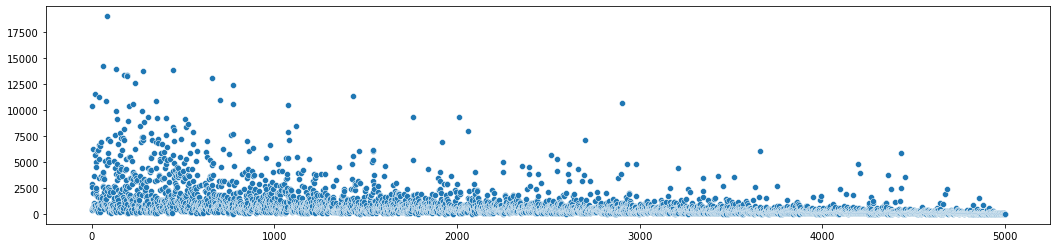

In [18]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_pure),show_graph=True)

=======analysis start=======
#all word size:  5000
#frequncy < 5:  2
#frequncy mean:  585.9322
#frequncy standard deviation:  1115.9149288378394
#frequncy std/mean:  1.9045120388294745


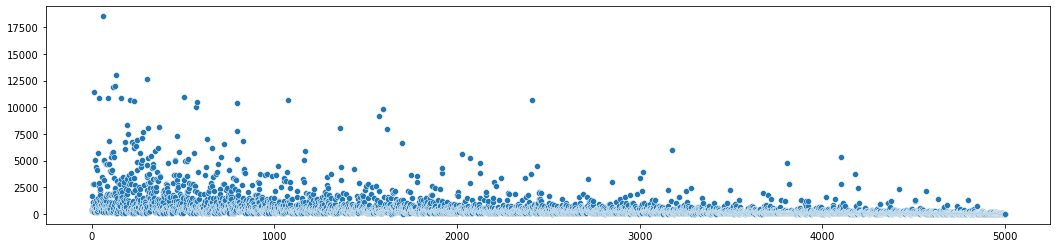

In [19]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_upper_max),show_graph=True)

In [20]:
skb_da_pure_limit = removeStopSememes(skb_da_pure,upper_limit=0.01,lower_limit=0)

=======analysis start=======
#all word size:  5000
#frequncy < 5:  0
#frequncy mean:  875.396
#frequncy standard deviation:  1449.2654401399354
#frequncy std/mean:  1.6555541036741492


=======analysis start=======
#all word size:  4950
#frequncy < 5:  0
#frequncy mean:  780.4511111111111
#frequncy standard deviation:  1079.0451663596941
#frequncy std/mean:  1.3825916204071786


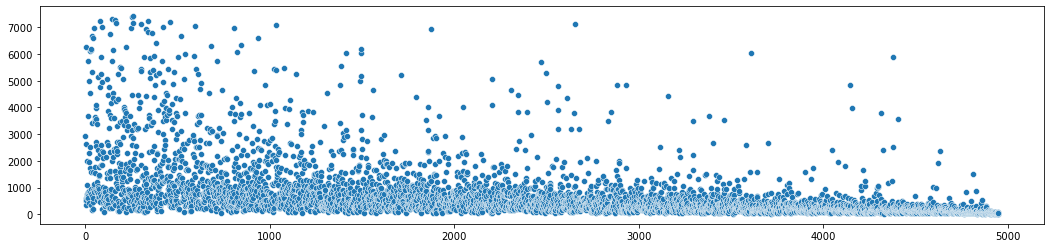

In [21]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_pure_limit),show_graph=True)

In [22]:
np.save(SKB_Benchmark_path+"/skb_da_pure_limit",skb_da_pure_limit)

## Function Definition

In [23]:
def clean_str(string,use=True):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    if not use: return string

    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [24]:
def load_stopwords(filepath):
    stopwords = set()
    with open(filepath, 'r') as f:
        for line in f:
            swd = line.strip()
            stopwords.add(swd)
    print(len(stopwords))
    return stopwords

In [25]:
def tf_idf_transform(inputs, mapping=None, sparse=False):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from scipy.sparse import coo_matrix
    vectorizer = CountVectorizer(vocabulary=mapping)
    tf_idf_transformer = TfidfTransformer()
    tf_idf = tf_idf_transformer.fit_transform(vectorizer.fit_transform(inputs))
    weight = tf_idf.toarray()
    return weight if not sparse else coo_matrix(weight)

In [26]:
def PMI(inputs, mapping, window_size, sparse):
    W_ij = np.zeros([len(mapping), len(mapping)], dtype=float)
    W_i = np.zeros([len(mapping)], dtype=float)
    W_count = 0
    for one in inputs:
        word_list = one.split(' ')
        if len(word_list) - window_size < 0:
            window_num = 1
        else:
            window_num = len(word_list) - window_size + 1

        for i in range(window_num):
            W_count += 1
            context = list(set(word_list[i:i + window_size]))
            while '' in context:
                context.remove('')
            for j in range(len(context)):
                W_i[mapping[context[j]]] += 1
                for k in range(j + 1, len(context)):
                    W_ij[mapping[context[j]], mapping[context[k]]] += 1
                    W_ij[mapping[context[k]], mapping[context[j]]] += 1

    if not sparse:
        PMI_adj = np.zeros([len(mapping), len(mapping)], dtype=np.float64)
        for i in range(len(mapping)):
            for j in range(len(mapping)):
                PMI_adj[i, j] = math.log(W_ij[i, j] * W_count / W_i[i] / W_i[j]) if W_ij[i, j] != 0 else 0
                if i == j: PMI_adj[i, j] = 1
                if PMI_adj[i, j] <= 0:
                    PMI_adj[i, j] = 0
    else:
        rows = []
        columns = []
        data = []
        for i in range(len(mapping)):
            for j in range(i, len(mapping)):
                value = math.log(W_ij[i, j] * W_count / W_i[i] / W_i[j]) if W_ij[i, j] != 0 else 0
                if i == j: value = 1
                if value > 0:
                    rows.append(i)
                    columns.append(j)
                    data.append(value)
                    if i != j:
                        rows.append(j)
                        columns.append(i)
                        data.append(value)
        PMI_adj = coo_matrix((data, (rows, columns)), shape=(len(mapping), len(mapping)))

    return PMI_adj

## Add Stopwords

In [479]:
def addStopWord(data_dict, stop_word):
    word_freq = defaultdict(int)
    for item in data_dict.keys():
        words = clean_str(item).split(' ')
        for one in words:
            word_freq[one.lower()] += 1
    freq_stop = 0
    for word, count in word_freq.items():
        if count < 5:
            stop_word.add(word)
            freq_stop += 1
    stop_word.add('')
    print('freq_stop num',freq_stop)
    return stop_word

In [477]:
stop_word = addStopWord(all_, load_stopwords(stopword_en_path))

408
freq_stop num 9108


In [478]:
len(stop_word)

9429

# Building Adjacency Matrix

## preprocession

In [480]:
def buildingAdj(all_data_dict, skb):
    adj_ent_index = []
    st_nodes = []
    tag_set = set()
    entity_set = set()
    words_set = set()
    all_idx = []
    labels = []
    tag_list = []
    word_list = []
    ent_mapping = {}
    
    for i, (sort_text, label) in enumerate(tqdm(all_data_dict.items())):
        sort_text = clean_str(sort_text)
        if not sort_text:
            print(sort_text)
            continue
        tags = [one[1].lower() for one in nltk.pos_tag(nltk.word_tokenize(sort_text))]
        if '' in tags: print("ERROR: ", item)
        tag_list.append(' '.join(tags))
        tag_set.update(tags)
        labels.append(label)
        words = [one.lower() for one in sort_text.split(' ') if one not in stop_word]
        if '' in words: print("ERROR: ", item)
        ent_list = []
        index = []
        ''' introduction skb '''
        for entity in skb.keys():
            if entity in words:
                ent_list.append(entity)
                if entity not in ent_mapping:
                    ent_mapping[entity] = len(ent_mapping)
                    entity_set.update(ent_list)
                if ent_mapping[entity] not in index: index.append(ent_mapping[entity])
        adj_ent_index.append(index)
        word_list.append(' '.join(words))
        words_set.update(words)
        if sort_text:
            st_nodes.append(sort_text)
        else:
            print("ERROR: ", i, sort_text)
        all_idx.append(len(all_idx))
    print("#tag_set", len(tag_set))
        
    multi_list = (all_idx, tag_list, word_list, labels)
    multi_set = (tag_set, entity_set, words_set)
    
    return st_nodes, ent_mapping, adj_ent_index, multi_list, multi_set

In [ ]:
skb_da_upper_max,skb_da_upper_max_sdv

In [481]:
st_nodes, ent_mapping, adj_ent_index, multi_list, multi_set = buildingAdj(all_, skb_da_upper_max)

100%|███████████████████████████████████████| 7398/7398 [10:40<00:00, 11.54it/s]

#tag_set 38


In [482]:
word_nodes = list(multi_set[2])
tag_nodes = list(multi_set[0])
entity_nodes = list(multi_set[1])

In [483]:
nodes_all = st_nodes + tag_nodes + entity_nodes + word_nodes
nodes_num = len(st_nodes) + len(tag_nodes) + len(entity_nodes) + len(word_nodes)

In [484]:
print('st', len(st_nodes))
print('tag', len(tag_nodes))
print('ent', len(entity_nodes))
print('word', len(word_nodes))

st 7398
tag 38
ent 2050
word 2526


In [485]:
building_adj_data = (st_nodes, ent_mapping, adj_ent_index, multi_list, multi_set)
np.save(STC_Benchmark_path+"/building_adj_data",building_adj_data)

## ST to POS TF-IDF 

In [486]:
tags_mapping = {key: value for value, key in enumerate(tag_nodes)}

In [487]:
adj_st2tag = tf_idf_transform(multi_list[1], tags_mapping)

In [488]:
print('adj_st2tag', np.mean(np.mean(adj_st2tag, -1)))

adj_st2tag 0.05509576840197963


In [489]:
pkl.dump(adj_st2tag, open('{}/{}_over/adj_st2tag.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## POS to POS PMI

In [490]:
adj_tag = PMI(multi_list[1], tags_mapping, window_size=5, sparse=False)

In [491]:
print('adj_tag', np.mean(np.mean(adj_tag, -1)))

adj_tag 0.3573684932758537


In [492]:
pkl.dump(adj_tag, open('{}/{}_over/adj_tag.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## ST to Word TFIDF

In [493]:
words_mapping = {key: value for value, key in enumerate(word_nodes)}

In [494]:
adj_st2word = tf_idf_transform(multi_list[2], words_mapping, sparse=True)

In [495]:
adj_st2word.toarray()[0][adj_st2word.toarray()[0] != 0]

array([0.44097356, 0.33664559, 0.26530549, 0.41362932, 0.42303795,
       0.29705743, 0.42840591])

In [496]:
print('adj_st2word', np.mean(np.mean(adj_st2word, -1)))

adj_st2word 0.0009715966886993158


In [497]:
pkl.dump(adj_st2word, open('{}/{}_over/adj_st2word.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## Word to Word PMI

In [498]:
adj_word = PMI(multi_list[2], words_mapping, window_size=5, sparse=True)

In [499]:
print('adj_word', np.mean(np.mean(adj_word, -1)))

adj_word 0.06531584714610006


In [500]:
pkl.dump(adj_word, open('{}/{}_over/adj_word.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## ST to Sememe TFIDF * SoftMax(LocalAttention)

In [501]:
ent_index_mapping = {index:word for word, index in ent_mapping.items()}

In [502]:
ent_list = [" ".join([ent_index_mapping[word_index] for word_index in sentence]) for sentence in adj_ent_index]

In [503]:
adj_st2ent = tf_idf_transform(ent_list, ent_mapping, sparse=True)

In [504]:
adj_st2ent.shape

(7398, 2050)

In [505]:
print('adj_st2ent', np.mean(np.mean(adj_st2ent, -1)))

adj_st2ent 0.0011117874671318433


### chose the best sense of each word

In [506]:
def CosineSimilarity(x1, x2):
    x2 = x2.t()
    x = x1.mm(x2)
    x1_frobenius = x1.norm(dim=1).unsqueeze(0).t()
    x2_frobenins = x2.norm(dim=0).unsqueeze(0)
    x_frobenins = x1_frobenius.mm(x2_frobenins)
    final = x.mul(1/x_frobenins)
    return final
def localAttention(sentence_str, word_str, sememe_list, embedding_dict):
    '''
        input: sentence_str, word_str, embedding_dict
        oytput: word embedding
    '''
    #print(sentence_str, word_str)
    context_embedding_list = []
    sentence_list = sentence_str.split()
    if sentence_str != word_str:
        sentence_list.remove(word_str)
    for word in sentence_list:
        if word in embedding_dict.keys():
            context_embedding_list.append(embedding_dict[word])
        else:
            context_embedding_list.append([0.0]*300)

    context_embedding_list = torch.Tensor(context_embedding_list).to(device)
    word_embedding = torch.from_numpy(embedding_dict[word_str]).float().unsqueeze(0).to(device)
    #print(context_embedding_list.size(),word_embedding.size())
    cos_value_w = CosineSimilarity(context_embedding_list, word_embedding).to(device)
    softmax_nn = nn.Softmax(dim=0)
    softmax_weight_w = softmax_nn(cos_value_w) * 4
    '''
        get local word embedding
    '''
    local_word_embedding = softmax_weight_w.t().mm(context_embedding_list)
    
    
    sememes_embedding_list = []
    for sememe in sememe_list:
        if sememe in embedding_dict.keys():
            sememes_embedding_list.append(embedding_dict[sememe])
        else:
            sememes_embedding_list.append([0.0]*300)
            
    sememes_embedding_list = torch.Tensor(sememes_embedding_list).to(device)
    cos_value_s = CosineSimilarity(sememes_embedding_list, local_word_embedding).to(device)
    softmax_weight_s = softmax_nn(cos_value_s)  * 4
    local_sememe_embedding = softmax_weight_s.t().mm(sememes_embedding_list)
    cos_value = CosineSimilarity(local_sememe_embedding,local_word_embedding)
    
    '''
        for 2ed weight
    '''
    
    cos_value_2w = CosineSimilarity(sememes_embedding_list, word_embedding).to(device)
    softmax_weight_2w = softmax_nn(cos_value_2w)
    
    multiply_weight = softmax_weight_2w*cos_value * 4
    
    return cos_value.to('cpu').squeeze(1).numpy().tolist(),\
            softmax_weight_2w.to('cpu').squeeze(1).numpy().tolist(),\
            multiply_weight.to('cpu').squeeze(1).numpy().tolist()

### On cuda

In [507]:
def replaceWord2Sememe(embedding_dict, skb_dict, docs_tuple,threshold,skb_cdv_map,ferquncy_max=0,overwrite=False):
    '''
        input: 
        process: if the word of sentence in skb && else if the freqency of word less then threshold:
                    replace the word to sememe:
                        if the sense of word only once:
                            straightforward replace else more thinking... of (sense dismatching- now leave aside)
                        else:
                            search the sentence embedding of docs by look-up embedding dictionary
                            for building the word embedding with weighted sum of sentence:
                                senses cosin = list
                                for index, sense the enumerate(senses):
                                    word cosin = list
                                    for sememe in sense:
                                        compare both that the embedding of the word and the sememe of the sense
                                        append the cosin value to word cosin list
                                    keep minimum of senses cosin to append the senses cosin list
                                get the index of minimum value for sense senses list
                                get the word via index with this word senses of SKB-DA
                            replace  
        return: docs list replaced with sememe
    '''
    sememe_docs_list = []
    second_weight_list = []
    '''
        threshold = np.mean(list(docs_tuple[0].values())) + np.std(list(word_freq.values())) /\
                np.mean(list(word_freq.values()))
    '''
    
    threshold = threshold
    ferquncy_max_word_list = [word for (word,_) in raw_word_freq_sorted[-round(ferquncy_max*len(docs_tuple[2])):]]
    for sentence in tqdm(docs_tuple[2]):
        sentence_replace = []
        weight_replace = []
        for word in sentence.split():
            #print("####",word)
            if word in skb_dict.keys() and (docs_tuple[0][word] < threshold or word in ferquncy_max_word_list):
                if len(skb_dict[word]) == 1:
                    if overwrite:
                        sentence_replace.append(["<S"+str(skb_cdv_map[sememe])+">" \
                                        for sememe in list(skb_dict[word][0][1])])
                    else:
                        if word in embedding_dict.keys():
                            st2sem_relation, word2sem_relation, multiply_weight = localAttention(sentence, word,\
                                                                                list(skb_dict[word][0][1]),\
                                                                                embedding_dict)
                            '''for sample weight'''
                            #weight_replace.append(word2sem_cos_list)
                            weight_replace.append(multiply_weight)
                        else:
                            weight_replace.append([1.0/len(skb_dict[word][0][1])]*len(skb_dict[word][0][1]))
                            
                            
                        sentence_replace.append(skb_dict[word][0][1])
                
                else:
                    if word not in embedding_dict.keys():
                        if overwrite:
                            sentence_replace.append(["<S"+str(skb_cdv_map[sememe])+">" \
                                              for sememe in list(skb_dict[word][0][1])])
                        else:
                            sememe_disambiguation = []
                            for (pos, sememe_set) in skb_dict[word]:
                                if pos == 'disambiguation' or pos == 'n' or pos == 'NN':
                                    sememe_disambiguation.append(sememe_set)
                            if len(sememe_disambiguation) == 0:
                                if dataset_name == 'Ohsumed':
                                    for (pos, sememe_set) in skb_dict[word]:
                                        if pos == 'chemotherapy':
                                            sememe_disambiguation.append(sememe_set)
                                print("No disambiguation")
                                print("ERROR: ", word, pos, sememe_set)
                                
                            weight_replace.append([1.0/len(sememe_disambiguation[0])]*\
                                                      len(sememe_disambiguation[0]))
                            sentence_replace.append(sememe_disambiguation[0])
                            
                    else:
                        senses_cos_list = []
                        word2sem_cos_list = []
                        multiply_cos_list = []
                        for (pos, sememe_set) in skb_dict[word]:
                            st2sem_relation, word2sem_relation, multiply_weight = localAttention(sentence, word,\
                                                                                  list(sememe_set),\
                                                                                  embedding_dict)
                            senses_cos_list.append(st2sem_relation)
                            word2sem_cos_list.append(word2sem_relation)
                            multiply_cos_list.append(multiply_weight)
                        if len(senses_cos_list) == 0:
                            print("ERROR: len(senses_cos_list) == 0")
                            print("ERROR: ", word, pos, sememe_set)
                            #sentence_replace.append(word)
                            continue
                        senses_cos_list_max_index = senses_cos_list.index(max(senses_cos_list))
                        if overwrite:
                            sentence_replace.apppend(["<S"+str(skb_cdv_map[sememe])+">" \
                                              for sememe in list(skb_dict[word][senses_cos_list_max_index][1])])
                        else:
                            sentence_replace.append(skb_dict[word][senses_cos_list_max_index][1])
                            '''for sample weight'''
                            #weight_replace.append(word2sem_cos_list[senses_cos_list_max_index])
                            weight_replace.append(multiply_cos_list[senses_cos_list_max_index])
                            
            else:
                continue
        sememe_docs_list.append(sentence_replace)
        second_weight_list.append(weight_replace)
    return sememe_docs_list,second_weight_list

### Load skb_da_pure

In [ ]:
skb_da_upper_max,skb_da_upper_max_sdv skb_da_upper_max_cdv

In [508]:
skb_da_pure = np.load(SKB_Benchmark_path+"/skb_da_upper_max_4.npy", allow_pickle=True).tolist()

In [509]:
skb_da_pure_cdv_set = np.load(SKB_Benchmark_path+"/skb_da_upper_max_cdv.npy", allow_pickle=True).tolist()
skb_da_cdv_map = {word:index for index, word in enumerate(skb_da_upper_max_sdv)}

### Build data tuple

In [510]:
raw_word_freq, raw_word_freq_sorted = evaluationFrequncy(ent_list)
doc_content_tuple = (raw_word_freq,raw_word_freq_sorted,ent_list)

=======analysis start=======
#all word size:  2050
#frequncy < 0:  0
#frequncy mean:  20.653658536585365
#frequncy standard deviation:  32.227984336908015
#frequncy std/mean:  1.5604007532040962


### conpute the local attention for sememe weight

In [511]:
sememe_docs_list,second_weight_list = replaceWord2Sememe(glove_840B_300d_common_crawl,\
                                                         skb_da_pure,\
                                                         doc_content_tuple,\
                                                         999999,\
                                                         skb_da_cdv_map)

100%|███████████████████████████████████████| 7398/7398 [03:46<00:00, 32.61it/s]


### check the local attention is work

In [512]:
def checkThelocalATT():
    if len(sememe_docs_list) != len(ent_list):
        print("ERROR:")
    for i in range(0,len(ent_list)):
        if len(sememe_docs_list[i]) != len(ent_list[i]):
            print("ERROR:",ent_list)

In [513]:
checkThelocalATT()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### TFIDF * localATT weight

In [514]:
def st2SemAdj(adj_st2ent,second_weight_list,sememe_docs_list,skb_da_cdv_map):
    
    st2sem_adj = np.zeros([len(sememe_docs_list), len(skb_da_cdv_map)], dtype=float)
    
    adj_st2ent_array = adj_st2ent.toarray()
    '''second_weight_list 10171 * #entity'''
    for i, ent_weight in enumerate(second_weight_list):
        local_adj_st2ent_array = adj_st2ent_array[i][adj_st2ent_array[i] != 0]
        '''ent_weight  #entity , j is entity index'''
        for j, sememe_weight in enumerate(ent_weight):
            if len(local_adj_st2ent_array) == len(ent_weight):
                '''adj_st2ent_array.shape (10171, 3801)'''
                final_weight = local_adj_st2ent_array[j] * np.array(sememe_weight)
            else:
                print("ERROR!",i,j)
                
            if len(sememe_docs_list[i][j]) == len(final_weight):
                for z, final_weight_value in enumerate(final_weight):
                    sem_index = skb_da_cdv_map[list(sememe_docs_list[i][j])[z]]
                    st2sem_adj[i,sem_index] = final_weight_value
                    #print(i,"---",sem_index,"---",final_weight_value)
            else:
                print("ERROR: ",sememe_docs_list[i][j], sememe_weight)
            
    return st2sem_adj
            

In [515]:
st2sem_adj = st2SemAdj(adj_st2ent,second_weight_list,sememe_docs_list,skb_da_cdv_map)

In [516]:
st2sem_adj.shape

(7398, 5000)

In [517]:
st2sem_adj[1][st2sem_adj[1] != 0]

array([0.23568627, 0.2326924 , 0.22158811, 0.22865896, 0.3051734 ,
       0.35423923, 0.21870649, 0.87530281, 0.34915092, 0.22401247,
       0.21689903])

In [518]:
st2sem_adj = np.nan_to_num(st2sem_adj)

In [519]:
print('st2sem_adj', np.mean(np.mean(st2sem_adj, -1)))

st2sem_adj 0.0009280749645341214


In [520]:
pkl.dump(st2sem_adj, open('{}/{}_over/adj_st2sem.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## Sememe to Sememe cosin

In [521]:
def getSkbEmbedding(skb_da_cdv_map,word_embedding_dict):
    skb_embedding_list = []
    oov_count = 0
    for key, value in skb_da_cdv_map.items():
        if key in word_embedding_dict.keys():
            skb_embedding_list.append(word_embedding_dict[key])
        else:
            oov_count += 1
            skb_embedding_list.append([0.0]*300)
    print("oov words: ", oov_count)
    return skb_embedding_list

In [522]:
skb_embedding_list = getSkbEmbedding(skb_da_cdv_map,glove_840B_300d_common_crawl)

oov words:  5


In [523]:
skb_embedding = np.array(skb_embedding_list)

In [524]:
print('ent shape', skb_embedding.shape)

ent shape (5000, 300)


In [525]:
ent_emb_normed = np.nan_to_num(skb_embedding / np.sqrt(np.square(skb_embedding).sum(-1, keepdims=True)))
adj_emb = np.matmul(ent_emb_normed, ent_emb_normed.transpose())
adj_emb = adj_emb * np.float32(adj_emb > 0)

/tmp/ipykernel_3509/1806021588.py:1: RuntimeWarning: invalid value encountered in true_divide
  ent_emb_normed = np.nan_to_num(skb_embedding / np.sqrt(np.square(skb_embedding).sum(-1, keepdims=True)))


In [526]:
print('entity_emb_cos', np.mean(np.mean(adj_emb, -1)))

entity_emb_cos 0.11822260281590367


In [527]:
pkl.dump(adj_emb, open('{}/{}_over/adj_sem.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## Save data of train + text

In [528]:
json.dump(multi_list[0], open('{}/{}_over/all_idx.json'.\
                              format(STC_Benchmark_path,dataset_name), 'w'), ensure_ascii=False)

## Save Label Map

In [555]:
if dataset_name == 'Ohsumed':
    label_set = set()
    Ohsumed_label_list = []
    labels_list = multi_list[3]
    for items in labels_list:
        label_set.add(items[0])
        Ohsumed_label_list.append(items[0])
    label_map = {value: i for i, value in enumerate(set(label_set))}
    json.dump([label_map[label] for label in Ohsumed_label_list],\
          open('{}/{}_over/labels.json'.format(STC_Benchmark_path,dataset_name), 'w'),ensure_ascii=False)
else:
    label_map = {value: i for i, value in enumerate(set(multi_list[3]))}
    json.dump([label_map[label] for label in multi_list[3]],\
          open('{}/{}_over/labels.json'.format(STC_Benchmark_path,dataset_name), 'w'),ensure_ascii=False)


##  Save Nodes

In [533]:
json.dump(st_nodes, open('{}/{}_over/st_id2_list.json'.\
                         format(STC_Benchmark_path,dataset_name), 'w'),ensure_ascii=False)

In [534]:
json.dump(tag_nodes, open('{}/{}_over/tag_id2_list.json'.\
                          format(STC_Benchmark_path,dataset_name), 'w'), ensure_ascii=False)

In [535]:
json.dump(word_nodes, open('{}/{}_over/word_id2_list.json'.\
                           format(STC_Benchmark_path,dataset_name), 'w'), ensure_ascii=False)

In [536]:
#json.dump(entity_nodes, open('./{}_data/entity_id2_list.json'.format(dataset_name), 'w'),ensure_ascii=False)

## Save Embeddings for Word nodes

In [537]:
def getWordNodesEmbedding(word_nodes,embedding_dict):
    embs = []
    err_count = 0
    for word in word_nodes:
        if word in embedding_dict.keys():
            embs.append(embedding_dict[word])
        else:
            err_count += 1
            embs.append(np.zeros(300, dtype=np.float64))
    print('err in word count', err_count)
    return embs

In [538]:
word_nodes_embedding = getWordNodesEmbedding(word_nodes, glove_840B_300d_common_crawl)

err in word count 8


In [539]:
print('word_nodes_embedding', np.mean(np.mean(word_nodes_embedding, -1)))

word_nodes_embedding 0.003765356770948485


In [540]:
pkl.dump(np.array(word_nodes_embedding, dtype=np.float64),\
         open('{}/{}_over/word_emb.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))